# 09-Hyperopt (using LGBM)

References: http://hyperopt.github.io/hyperopt/ , https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt

Hyperopt uses bayesian optimization for hyperparameter optimization.

Search algorithm 'tpe.suggest' is used (Tree of Parzen Estimators)

### Imports

In [1]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns

In [2]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)

### Load Train Data

In [3]:
data_dir = Path('../../dacon-inputs/dankook/input')
sub_dir = Path('../../dacon-inputs/dankook/sub')
feature_dir = Path('../../dacon-inputs/dankook/feature')
val_dir = Path('../../dacon-inputs/dankook/val')
tst_dir = Path('../../dacon-inputs/dankook/tst')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3 # b/c class is 0, 1, 2?
seed = 42

In [4]:
data_dir.resolve()

WindowsPath('C:/Users/bryan/dacon-inputs/dankook/input')

In [5]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


### Hyperparameter Tuning

In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [10]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

# Defining search space
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])
}

In [11]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|███████████████████████████████████████████████| 10/10 [08:23<00:00, 50.30s/trial, best loss: 0.16233886405560138]
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.8, 'learning_rate': 0.048650015180814125, 'min_child_samples': 25, 'num_leaves': 127, 'subsample': 0.9}


### Stratified K-Fold Cross Validation

In [12]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

### Train LightGBM Classifier

In [13]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.921223
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.863938
[3]	valid_0's multi_logloss: 0.809627
[4]	valid_0's multi_logloss: 0.760532
[5]	valid_0's multi_logloss: 0.716641
[6]	valid_0's multi_logloss: 0.681618
[7]	valid_0's multi_logloss: 0.648071
[8]	valid_0's multi_logloss: 0.620471
[9]	valid_0's multi_logloss: 0.592277
[10]	valid_0's multi_logloss: 0.563433
[11]	valid_0's multi_logloss: 0.537566
[12]	valid_0's multi_logloss: 0.513833
[13]	valid_0's multi_logloss: 0.491963
[14]	valid_0's multi_logloss: 0.470977
[15]	valid_0's multi_logloss: 0.451777
[16]	valid_0's multi_logloss: 0.434603
[17]	valid_0's multi_logloss: 0.418595
[18]	valid_0's multi_logloss: 0.40342
[19]	valid_0's multi_logloss: 0.388954
[20]	valid_0's multi_logloss: 0.376948
[21]	valid_0's multi_logloss: 0.364363
[22]	valid_0's multi_logloss: 0.352771
[23]	valid_0's multi_logloss: 0.341702
[24]	valid_0's multi_loglos

[209]	valid_0's multi_logloss: 0.160035
[210]	valid_0's multi_logloss: 0.160037
[211]	valid_0's multi_logloss: 0.160006
[212]	valid_0's multi_logloss: 0.159966
[213]	valid_0's multi_logloss: 0.159942
[214]	valid_0's multi_logloss: 0.159901
[215]	valid_0's multi_logloss: 0.159891
[216]	valid_0's multi_logloss: 0.159885
[217]	valid_0's multi_logloss: 0.159864
[218]	valid_0's multi_logloss: 0.159862
[219]	valid_0's multi_logloss: 0.159857
[220]	valid_0's multi_logloss: 0.159846
[221]	valid_0's multi_logloss: 0.159824
[222]	valid_0's multi_logloss: 0.159807
[223]	valid_0's multi_logloss: 0.159778
[224]	valid_0's multi_logloss: 0.15977
[225]	valid_0's multi_logloss: 0.15976
[226]	valid_0's multi_logloss: 0.159736
[227]	valid_0's multi_logloss: 0.159727
[228]	valid_0's multi_logloss: 0.159743
[229]	valid_0's multi_logloss: 0.15972
[230]	valid_0's multi_logloss: 0.159717
[231]	valid_0's multi_logloss: 0.159675
[232]	valid_0's multi_logloss: 0.159675
[233]	valid_0's multi_logloss: 0.15967
[234

[150]	valid_0's multi_logloss: 0.16201
[151]	valid_0's multi_logloss: 0.161967
[152]	valid_0's multi_logloss: 0.161933
[153]	valid_0's multi_logloss: 0.161898
[154]	valid_0's multi_logloss: 0.161872
[155]	valid_0's multi_logloss: 0.161826
[156]	valid_0's multi_logloss: 0.161803
[157]	valid_0's multi_logloss: 0.161757
[158]	valid_0's multi_logloss: 0.161746
[159]	valid_0's multi_logloss: 0.161699
[160]	valid_0's multi_logloss: 0.161668
[161]	valid_0's multi_logloss: 0.16164
[162]	valid_0's multi_logloss: 0.16161
[163]	valid_0's multi_logloss: 0.161562
[164]	valid_0's multi_logloss: 0.161516
[165]	valid_0's multi_logloss: 0.161478
[166]	valid_0's multi_logloss: 0.161427
[167]	valid_0's multi_logloss: 0.161381
[168]	valid_0's multi_logloss: 0.161349
[169]	valid_0's multi_logloss: 0.161304
[170]	valid_0's multi_logloss: 0.161274
[171]	valid_0's multi_logloss: 0.161243
[172]	valid_0's multi_logloss: 0.161189
[173]	valid_0's multi_logloss: 0.161169
[174]	valid_0's multi_logloss: 0.161125
[17

[59]	valid_0's multi_logloss: 0.194803
[60]	valid_0's multi_logloss: 0.193588
[61]	valid_0's multi_logloss: 0.192259
[62]	valid_0's multi_logloss: 0.191125
[63]	valid_0's multi_logloss: 0.189921
[64]	valid_0's multi_logloss: 0.188702
[65]	valid_0's multi_logloss: 0.187725
[66]	valid_0's multi_logloss: 0.186573
[67]	valid_0's multi_logloss: 0.1855
[68]	valid_0's multi_logloss: 0.18448
[69]	valid_0's multi_logloss: 0.183538
[70]	valid_0's multi_logloss: 0.182656
[71]	valid_0's multi_logloss: 0.181981
[72]	valid_0's multi_logloss: 0.181281
[73]	valid_0's multi_logloss: 0.180675
[74]	valid_0's multi_logloss: 0.180094
[75]	valid_0's multi_logloss: 0.179457
[76]	valid_0's multi_logloss: 0.178716
[77]	valid_0's multi_logloss: 0.178207
[78]	valid_0's multi_logloss: 0.177632
[79]	valid_0's multi_logloss: 0.17697
[80]	valid_0's multi_logloss: 0.176447
[81]	valid_0's multi_logloss: 0.175878
[82]	valid_0's multi_logloss: 0.17531
[83]	valid_0's multi_logloss: 0.17477
[84]	valid_0's multi_logloss: 0

[15]	valid_0's multi_logloss: 0.452915
[16]	valid_0's multi_logloss: 0.435745
[17]	valid_0's multi_logloss: 0.419872
[18]	valid_0's multi_logloss: 0.404761
[19]	valid_0's multi_logloss: 0.390298
[20]	valid_0's multi_logloss: 0.378343
[21]	valid_0's multi_logloss: 0.365873
[22]	valid_0's multi_logloss: 0.354351
[23]	valid_0's multi_logloss: 0.343258
[24]	valid_0's multi_logloss: 0.334367
[25]	valid_0's multi_logloss: 0.325545
[26]	valid_0's multi_logloss: 0.317639
[27]	valid_0's multi_logloss: 0.309298
[28]	valid_0's multi_logloss: 0.30136
[29]	valid_0's multi_logloss: 0.293919
[30]	valid_0's multi_logloss: 0.287373
[31]	valid_0's multi_logloss: 0.280778
[32]	valid_0's multi_logloss: 0.275048
[33]	valid_0's multi_logloss: 0.26919
[34]	valid_0's multi_logloss: 0.263735
[35]	valid_0's multi_logloss: 0.258342
[36]	valid_0's multi_logloss: 0.254064
[37]	valid_0's multi_logloss: 0.249428
[38]	valid_0's multi_logloss: 0.245044
[39]	valid_0's multi_logloss: 0.241293
[40]	valid_0's multi_loglos

[223]	valid_0's multi_logloss: 0.161478
[224]	valid_0's multi_logloss: 0.161464
[225]	valid_0's multi_logloss: 0.161461
[226]	valid_0's multi_logloss: 0.16145
[227]	valid_0's multi_logloss: 0.161451
[228]	valid_0's multi_logloss: 0.161444
[229]	valid_0's multi_logloss: 0.161439
[230]	valid_0's multi_logloss: 0.161473
[231]	valid_0's multi_logloss: 0.161464
[232]	valid_0's multi_logloss: 0.161454
[233]	valid_0's multi_logloss: 0.161444
[234]	valid_0's multi_logloss: 0.16143
[235]	valid_0's multi_logloss: 0.161427
[236]	valid_0's multi_logloss: 0.161424
[237]	valid_0's multi_logloss: 0.16142
[238]	valid_0's multi_logloss: 0.16143
[239]	valid_0's multi_logloss: 0.161426
[240]	valid_0's multi_logloss: 0.161429
[241]	valid_0's multi_logloss: 0.161414
[242]	valid_0's multi_logloss: 0.161387
[243]	valid_0's multi_logloss: 0.16138
[244]	valid_0's multi_logloss: 0.161383
[245]	valid_0's multi_logloss: 0.161379
[246]	valid_0's multi_logloss: 0.161383
[247]	valid_0's multi_logloss: 0.161374
[248]

[152]	valid_0's multi_logloss: 0.161666
[153]	valid_0's multi_logloss: 0.161639
[154]	valid_0's multi_logloss: 0.161583
[155]	valid_0's multi_logloss: 0.161541
[156]	valid_0's multi_logloss: 0.161463
[157]	valid_0's multi_logloss: 0.161442
[158]	valid_0's multi_logloss: 0.161411
[159]	valid_0's multi_logloss: 0.161377
[160]	valid_0's multi_logloss: 0.161348
[161]	valid_0's multi_logloss: 0.161299
[162]	valid_0's multi_logloss: 0.161255
[163]	valid_0's multi_logloss: 0.161236
[164]	valid_0's multi_logloss: 0.161184
[165]	valid_0's multi_logloss: 0.16115
[166]	valid_0's multi_logloss: 0.161119
[167]	valid_0's multi_logloss: 0.161087
[168]	valid_0's multi_logloss: 0.161043
[169]	valid_0's multi_logloss: 0.161023
[170]	valid_0's multi_logloss: 0.160991
[171]	valid_0's multi_logloss: 0.160974
[172]	valid_0's multi_logloss: 0.160954
[173]	valid_0's multi_logloss: 0.160927
[174]	valid_0's multi_logloss: 0.160899
[175]	valid_0's multi_logloss: 0.160865
[176]	valid_0's multi_logloss: 0.16085
[1

In [14]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.3119%


In [15]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [16]:
# Stacking에 사용
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

### Visualize Feature Importance

<AxesSubplot:ylabel='feature'>

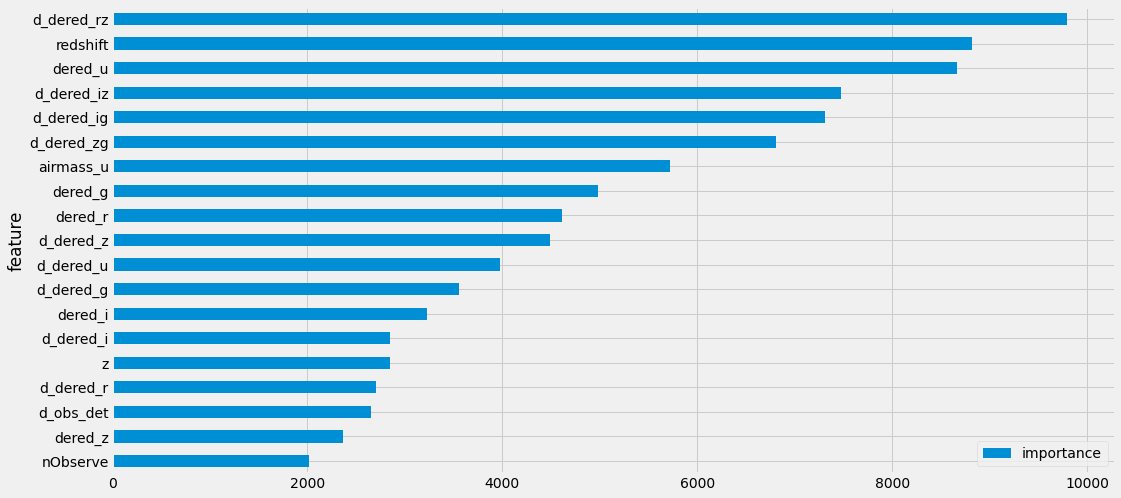

In [18]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### Create Submission File

In [19]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [20]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [21]:
sub[target_col].value_counts()

2    41033
0    29968
1     8999
Name: class, dtype: int64

### Saving Submission File

In [22]:
sub.to_csv(sub_file)